<a href="https://colab.research.google.com/github/carlosfmorenog/CMM536/blob/master/CMM536_Topic_5/CMM536_T5_Lab_Solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic 5 Laboratory (Solved)

In this activity you will use `Tensorflow` to apply image augmentation to an image repository which is normally used to train deep learning models.

To see the original tutorial, you can visit [this site](https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/).

## Installing the necessary packages

We will use [Tensorflow](https://www.tensorflow.org/), which is a very popular deep learning library in Python, to create our image augmentation model. To install it, run the cell below:

In [ ]:
!pip install tensorflow
!pip install --upgrade tensorflow # make sure you have TF >2.1

To start our practice, we will import `Tensorflow` along with `numpy` and `matplotlib.pyplot` by running the following cell:

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Loading the Data

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset can be imported directly by `Tensorflow`. In fact the dataset contains more than 170 million images! We will download all of them in a reduced format, and import only a very small batch to train the image augmentation functions:

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


The next cell contains a function where you can specify as input the number of images from CIFAR-10 that you want, and will return to you a sample dataset:

In [ ]:
def create_dataset(number_images):
    return tf.data.Dataset.from_tensor_slices((x_train[0:number_images] / 255).astype(np.float32))

The next cell contains a function to plot images that you requested, along with a certain number of samples per image. You will notice along this practice that it is thanks to this function that you will be able to get all outputs.

In [ ]:
def plot_images(dataset, n_images, samples_per_image):
    output = np.zeros((32 * n_images, 32 * samples_per_image, 3))
    row = 0
    for images in dataset.repeat(samples_per_image).batch(n_images):
        output[:, row*32:(row+1)*32] = np.vstack(images.numpy())
        row += 1
    plt.figure()
    plt.imshow(output)
    plt.show()
    return

Run the following cell changing the value of `n` and `m` to see different number of images and samples per images respectively:

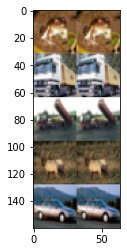

In [ ]:
n=5
m=2
imgs = create_dataset(n)
plot_images(imgs, n, m)

## Creating a Tensor

One of the most interesting features of `Tensorflow` is the use of **tensors**. Tensors are a generalisation of vectors and matrices with potential higher dimension[$^1$](https://www.tensorflow.org/guide/tensor). Since objects used in deep learning usually contain millions of samples, it is easier to use tensors rather than conventional functions.

For instance, suppose that you want to create an `augment()` function which will multiply your original samples. The tensor for that function will have the following structure:

In [ ]:
## If you run this cell, nothing will happen
def augment(x: tf.Tensor) -> tf.Tensor:
    """This function will augment the image dataset based on your parameters
    Input:
        x: Image
    Output:
        Augmented image"""
    return x

## Image Rotation

`Tensorflow` already contains several functions that can be used to manipulate images. We will design tensors to fit those functions for our sample repository. The next cell will define the a random rotation in four different angles: 0, 90, 180 and 270 degrees.

In [ ]:
#Again, you'll get n output
def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation"""
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

To use the tensor, we need to apply the `map()` Tensor function to the dataset as follows:

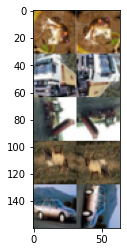

In [ ]:
imgs2 = imgs.map(rotate,)
plot_images(imgs2, n, m)

Notice that although you cannot change the value of `n` (unless you import again the repository by running the `create_dataset()` function again), you can always change the number of samples `m`. That is the beauty of tensors!

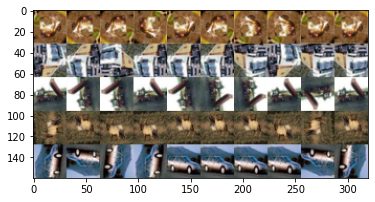

In [ ]:
## Use this cell to map the rotation tensor and print a different number of samples
imgs2 = imgs.map(rotate)
plot_images(imgs2, n, 10)

## Flip

Now we will define the flip:

In [ ]:
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation"""
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return x

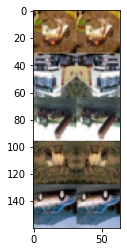

In [ ]:
## Use this cell to map and verify the flip
imgs2 = imgs.map(flip)
plot_images(imgs2, n, m)

### Changing the colour

You get the idea by now, run the cell and test the tensor!

In [ ]:
def colour(x: tf.Tensor) -> tf.Tensor:
    """Colour augmentation"""
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


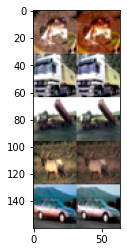

In [ ]:
## Use this cell to map and verify the colour
imgs2 = imgs.map(colour)
plot_images(imgs2, n, m)

### Applying more than one transformation simultaneously

We can combine multiple transformations and use them at the same time.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


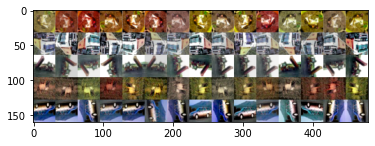

In [ ]:
# Add augmentations
augmentations = [rotate, flip, colour]
# Add the augmentations to the dataset
for f in augmentations:
    # Apply the augmentation, run 4 jobs in parallel.
    imgs = imgs.map(f, num_parallel_calls=1)
plot_images(imgs, n, 15)

Notice we have to do this in `imgs` (the original dataset) instead of creating a new dataset `imgs2`

## Zoom

Now it's your turn to add the zoom into the model. The outcome of this transformation may not be very visible for the `CIFAR-10` dataset, but is a very widely used technique, especially when you want to train detection models where you don't know the scale of the images that you want to localise!

This function is harder to understand, in fact it contains a function `random_crop()` inside!

In [ ]:
## Use the cell below to define the zoom function
def zoom(x: tf.Tensor) -> tf.Tensor:
    """Zoom augmentation"""
    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))
    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]
    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(32, 32))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]
    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

Use the following cell to run the `zoom` tensor, printing 20 samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


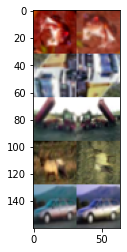

In [ ]:
imgs2 = imgs.map(zoom)
plot_images(imgs2, n, m)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


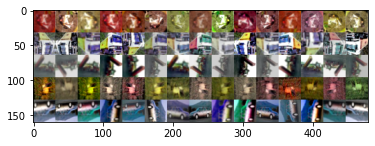

In [ ]:
## Use this cell  to run the model with flip, rotate, colour, zoom & plot afterwards
# Add augmentations
augmentations = [rotate, flip, colour, zoom]
# Add the augmentations to the dataset
for f in augmentations:
    # Apply the augmentation, run 4 jobs in parallel.
    imgs = imgs.map(f, num_parallel_calls=1)
plot_images(imgs, n, 15)

## Bonus 1: Augment your own images!

Import a repository of images form your computer, convert it into a `DatasetV1Adapter` and apply the tensors designed in this tutorial to augment your own dataset.

## Bonus 2: Image augmentation using Keras

As explained in the lecture, there are many ways to do image augmentation. There is another tutorial [here](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) which uses the popular `Keras` API and their image preprocessing functions. You can find more about it [here](https://keras.io/preprocessing/image/).

[Keras](https://keras.io/) typically runs using the [theano](http://deeplearning.net/software/theano/) back-end to do the calculations. You can install both by running the following cell:

In [ ]:
!pip install keras
!pip install theano

     |████████████████████████████████| 2.8 MB 4.8 MB/s 
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668111 sha256=30ae7c33dcabe5b55139935c1b6562789691e33a8df9626b9651e0a286f80d17
  Stored in directory: /root/.cache/pip/wheels/26/68/6f/745330367ce7822fe0cd863712858151f5723a0a5e322cc144
Successfully built theano


When running keras/theano for the first time IN YOUR PC, you may be prompted with an error message telling you that `theano` has no attribute `gof` due to `g++` not being installed.

In [ ]:
import keras
import theano

 You can find instructions on how to download and install the g++ compiler [here](http://www.cs.utah.edu/~alee/g++/g++old.html).